In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
#Data Preprocessing with Bank Marketing Dataset
Bank_data = pd.read_csv('bank-additional.csv', delimiter = ';')
Bank_data.dropna().head(5)

age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri ...         2    999         0  nonexistent   
1  telephone   may         fri ...         4    999         0  nonexistent   
2  telephone   jun         wed ...         1    999         0  nonexistent   
3  telephone   jun         fri ...         3    999         0  nonexistent   
4   cellular   nov         mon ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0         -1.8          92.893          -46.2      1.313       5099.1  no  
1          1.1          93.994          -36.4      4.855       5191.0  no  
2          1.4          94.465          -41.8      4.962       5228.1  no  
3          1.4          94.465          -41.8      4.959       5228.1  no  
4         -0.1          93.200          -42.0      4.191       5195.8  no  

[5 rows x 21 columns]

In [9]:
count_list = []
for column in Bank_data.columns[1:7]:
    unknown = get_unknown_value(Bank_data, column)
    count_list.append(unknown)

Text(0.5,1,'Unknown Values for Each Features')

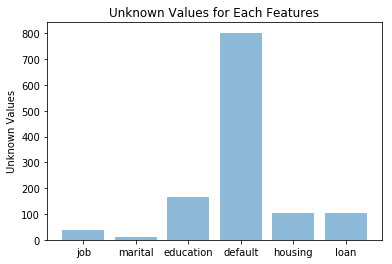

In [10]:
objects = ('job', 'marital', 'education', 'default', 'housing', 'loan')
y_pos = np.arange(len(objects))
plt.bar(y_pos, count_list, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Unknown Values')
plt.title('Unknown Values for Each Features')

In [ ]:
The unknown values for job, marital, education, default, housing and loan are shown above. 
Except for default, these are only a small part values, so we filled the unknown values
with the mode value of that specific column. The unknown value in 'default' is around 800, 
so we just dropped this feature.

In [11]:
#Replacing unknown values with most frequent values in the column
for column in Bank_data.columns[1:8]:
    Bank_data[column] = Bank_data[column].where(Bank_data[column] != 'unknown', Bank_data[column].mode()[0])

In [ ]:
After exploring the data and analyzing all the visualization in the previous exercise lab, we conclude to drop the features such as 'contact', 'month','duration','default',
all other features would impact the chances of customer subscription.

In [55]:
#Split the dataset
def split_DataSet(Dataset, size):
        msk = np.random.rand(len(Dataset))<size
        Data_train = Dataset[msk]
        Data_test = Dataset[~msk]
        return Data_train,Data_test
#Normalize the columns
def normalize(x):
    return (x-min(x))/(max(x)-min(x))
#Logistic function sigma for Bank dataset
def P(x):
    return 1.0/(1.0 + np.exp(-x))
#Error for wine dataset 
def RMSE(y,y_pred):
    return np.sqrt(1.0 * np.mean((y - y_pred)**2))
#Logloss error for bank dataset
def error(y, p):
    return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
#Regularization
def l2Loss(lamda, weight):
    loss = 2 * lamda * weight
    loss[0] = 0
    return loss
#Logistic regression with Mini batch Gradient Descent 
def logisticregminibatch(xTrain, yTrain, xTest, yTest, beta, epochs = 10, batchSize = 50, alpha = 3e-5, 
                             regularizationParameter = 1e-2, regularization = None):
    xTrain = np.insert(xTrain, 0, 1, axis=1)
    xTest = np.insert(xTest, 0, 1, axis=1)
    x = xTrain * 1.0
    y = yTrain * 1.0
    xTest = xTest * 1.0
    yTest = yTest * 1.0        
    plot_logLossTrain = []
    plot_logLossTest = []
    ind = np.arange(0, len(xTrain))        
    for i in range (0, epochs):                                 
        np.random.shuffle(ind)
        batches = np.array_split(ind, batchSize)
        index = 0
        while index < len(xTrain):
            batch = ind[index : index + batchSize]
            index = index + batchSize
            x = np.take(xTrain, batch, axis = 0)
            y = np.take(yTrain, batch, axis = 0)            
            #prediction & Gradient for Bank dataset 
            #p = P(np.dot(beta, x.T))
            #gradient = np.dot(x.T, p - y)             
            #prediction & Gradient for wine dataset 
            p = np.dot(beta, x.T)
            residual = p - y
            gradient = np.dot(residual, x) * 2            
            regloss = 0
            if regularization != None:
                regloss = regularization(regularizationParameter, beta)                
            beta = beta - (alpha * (gradient + regloss))              
        #plot for logloss of Bank dataset 
        #plot_logLossTrain.append(error(yTrain, P(np.dot(beta, xTrain.T))))
        #plot_logLossTest.append(error(yTest, P(np.dot(beta, xTest.T))))        
        #plot for RMSE of wine dataset
        xTrainP = np.dot(beta, xTrain.T)
        xTestP = np.dot(beta, xTest.T)
        plot_logLossTrain.append(RMSE(yTrain, xTrainP))
        plot_logLossTest.append(RMSE(yTest, xTestP))
    return beta, plot_logLossTrain, plot_logLossTest
def kFold_Cross_Validation(xTrain, yTrain, model, modelParameters, nFolds):    
    ind = np.array(range(0, len(xTrain)))
    folds = np.array_split(ind, nFolds)    
    minlosslist = []
    plot_logLossTrain = []
    plot_logLossTest = []    
    for i in range(0, len(folds)):
        validationSet = folds[i]
        trainSet = np.setdiff1d(ind, validationSet)        
        modelParameters['xTrain'] = np.take(xTrain, trainSet, axis = 0)
        modelParameters['yTrain'] = np.take(yTrain, trainSet, axis = 0)
        modelParameters['xTest'] = np.take(xTrain, validationSet, axis = 0)
        modelParameters['yTest'] = np.take(yTrain, validationSet, axis = 0)        
        modelParams, trainLoss, testLoss = model(**modelParameters)
        minlosslist.append(testLoss[-1])
        plot_logLossTrain.append(trainLoss)
        plot_logLossTest.append(testLoss)        
    return modelParams, plot_logLossTrain, plot_logLossTest, minlosslist
def gridSearch(xTrain, yTrain, xTest, yTest, model, modelParameters, hyperParameters, nFolds = 1):
    leastLoss = None
    bestModel = None
    bestHyperParams = None
    parameterGrid = []
    gridKeys = []
    index = 0  
    parameterGrid = list(product(*hyperParameters.values()))
    hyperParameterKeys = hyperParameters.keys()
    plt.close()
    fig, axs = plt.subplots(len(parameterGrid), 2, figsize=(20, 10 * len(parameterGrid)))
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax3d = fig.add_subplot(111, projection='3d')
    for parameterMesh in parameterGrid:
        hyperParameterMesh = {}
        for k,v in zip(hyperParameterKeys, parameterMesh):
            hyperParameterMesh[k] = v
            #print("mesh",hyperParameterMesh)
        updatedParam = modelParameters.copy()
        updatedParam.update(hyperParameterMesh)        
        if nFolds > 1:
            modelParams, trainLossList, testLossList, minlosslist = kFold_Cross_Validation(model = model,
                                                                                        xTrain = xTrain,
                                                                                        yTrain = yTrain,
                                                                                        nFolds = nFolds,
                                                                                        modelParameters = updatedParam)              
            
            avg = np.average(minlosslist)
            if leastLoss == None or avg < leastLoss:
                leastLoss = avg
                bestModel = modelParams
                bestHyperParams = hyperParameterMesh            
            k = 1
            ax3d.scatter(hyperParameterMesh['alpha'], hyperParameterMesh['regularizationParameter'], 
                           avg, marker = 'o', label = str(hyperParameterMesh))
            for train, test in zip(trainLossList, testLossList):
                axs[index][0].plot(train, label = "Fold-" + str(k))
                axs[index][1].plot(test, label = "Fold-" + str(k))
                k = k + 1             
            axs[index][0].legend()
            axs[index][0].grid()
            axs[index][1].legend()
            axs[index][1].grid()
            axs[index][0].set_title("Train set for " + str(hyperParameterMesh))
            axs[index][1].set_title("Validation set for " + str(hyperParameterMesh))
            index = index + 1            
        else:
            trainedModel, trainLoss, testLoss = model(xTrain, yTrain, xTest, yTest, **updatedParam)
            if leastLoss == None or testLoss[-1] < leastLoss:
                leastLoss = testLoss[-1]
                bestModel = trainedModel
                bestHyperParams = hyperParameterMesh
            axs[index][0].plot(trainLoss, label = "Training set Loss for " + str(hyperParameterMesh))
            axs[index][0].legend()
            axs[index][0].grid()
            axs[index][1].plot(testLoss, label = "Test set Loss for " + str(hyperParameterMesh))
            axs[index][1].legend()
            axs[index][1].grid()
            index = index + 1            
    ax3d.legend()
    ax3d.set_xlabel('alpha')
    ax3d.set_ylabel('regularizationParameter')
    ax3d.set_zlabel('RMSE')
    plt.show()
    plt.close()        
    updatedParam = modelParameters.copy()
    updatedParam.update(bestHyperParams)
    bestModel, trainLoss, testLoss = model(xTrain, yTrain, xTest, yTest, **updatedParam)
    print("Trainloss :"+str(trainLossNonReg[-1]))
    print("Testloss :"+str(trainLossReg[-1]))
    plt.close()
    plotHeight = 10
    plotWidth = 20
    fig, axes = plt.subplots(1, 2, figsize = (plotWidth, plotHeight)) 
    plt.suptitle("Best model")
    axes[0].plot(trainLoss, label = "Training set Loss for " + str(bestHyperParams))
    axes[0].legend()
    axes[0].grid()
    axes[1].plot(testLoss, label = "Test set Loss for " + str(bestHyperParams))
    axes[1].legend()
    axes[1].grid()
    plt.show()
    return bestModel, bestHyperParams          

In [13]:
#BankData Preprocessing
Bank_data = Bank_data.drop(['contact','month','duration','default','day_of_week', 'housing', 'age', 'campaign', 'cons.conf.idx','cons.price.idx'], axis = 1)
Bank_data.shape

(4119, 11)

In [14]:
#Replacing the target variables with 1 and 0
Bank_data.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [15]:
#conveting non numeric fields into numeric fields
Bank_data = pd.get_dummies(Bank_data)
Bank_data.head()

pdays  previous  emp.var.rate  euribor3m  nr.employed  y  job_admin.  \
0    999         0          -1.8      1.313       5099.1  0           0   
1    999         0           1.1      4.855       5191.0  0           0   
2    999         0           1.4      4.962       5228.1  0           0   
3    999         0           1.4      4.959       5228.1  0           0   
4    999         0          -0.1      4.191       5195.8  0           1   

   job_blue-collar  job_entrepreneur  job_housemaid        ...         \
0                1                 0              0        ...          
1                0                 0              0        ...          
2                0                 0              0        ...          
3                0                 0              0        ...          
4                0                 0              0        ...          

   education_basic.9y  education_high.school  education_illiterate  \
0                   1                      0                     0   
1                   0                      1                     0   
2                   0                      1                     0   
3                   1                      0                     0   
4                   0                      0                     0   

   education_professional.course  education_university.degree  loan_no  \
0                              0                            0        1   
1                              0                            0        1   
2                              0                            0        1   
3                              0                            0        1   
4                              0                            1        1   

   loan_yes  poutcome_failure  poutcome_nonexistent  poutcome_success  
0         0                 0                     1                 0  
1         0                 0                     1                 0  
2         0                 0                     1                 0  
3         0                 0                     1                 0  
4         0                 0                     1                 0  

[5 rows x 32 columns]

In [16]:
#Normalisation
Bank_data['nr.employed'] = normalize(Bank_data['nr.employed'])
Bank_data['pdays'] = normalize(Bank_data['pdays'])

In [17]:
#Splitting dataset into train and test data
x_Train, x_Test = split_DataSet(Bank_data, 0.8)
y_Train = x_Train['y']
y_Test = x_Test['y']
x_Train = x_Train.drop('y', axis = 1)
x_Test = x_Test.drop('y', axis = 1)
x_Train = x_Train.as_matrix()
x_Test = x_Test.as_matrix()
y_Train=y_Train.as_matrix()
y_Test=y_Test.as_matrix()
print("Training data size " + str(x_Train.shape))
print("Training data size "+ str(x_Test.shape))

Training data size (3301, 31)
Training data size (818, 31)


C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Iteration = 1 Alpha = 7e-07 lambda = 0.0003
Non Regularized Trainloss :1112.6079242404826
Regularised Trainloss :1112.606276418896
Iteration = 2 Alpha = 1e-05 lambda = 0.0006
Non Regularized Trainloss :995.8847812958982
Regularised Trainloss :995.8862818646103
Iteration = 3 Alpha = 0.006 lambda = 0.0009
Non Regularized Trainloss :948.8607428521532
Regularised Trainloss :946.1131216826496


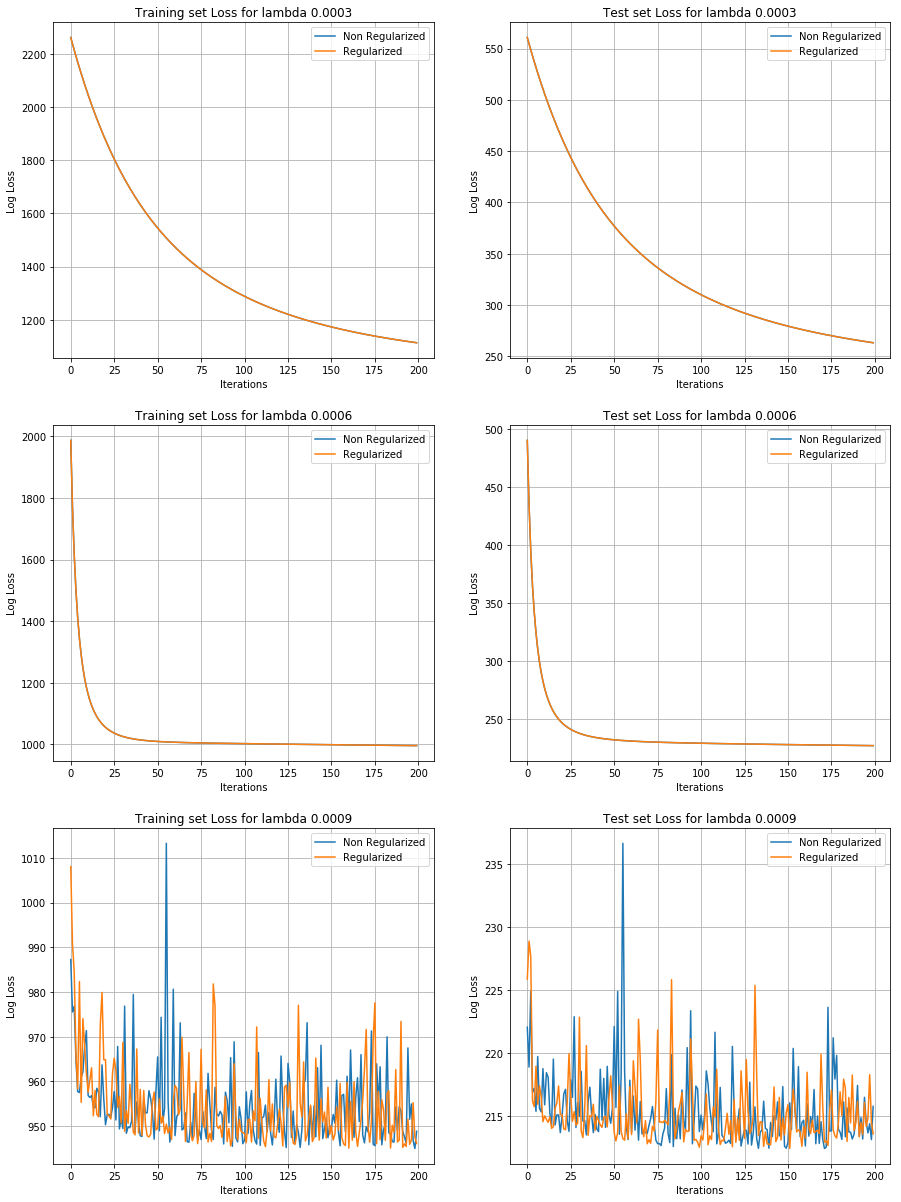

In [32]:
#Mini Batch Gradient Decent for Bank Dataset with regularisation
plt.close()
modelParameters = {"beta":np.zeros(x_Train.shape[1] + 1), "epochs":200, 
                   "batchSize":50}
alphaList = [7e-7, 1e-5, 6e-3]
regularizationParameterList = [3e-4, 6e-4, 9e-4]
index = 0
fig, axs = plt.subplots(len(alphaList), 2, figsize=(15, 7 * len(alphaList)))
#print("axs :"+str(axs))
for alpha, regularizationParameter in zip(alphaList, regularizationParameterList):
    betaNonReg, trainLossNonReg, testLossNonReg = logisticregminibatch(x_Train, y_Train, x_Test
                                                                       , y_Test,alpha = alpha, **modelParameters)
    
    
    betaReg, trainLossReg, testLossReg = logisticregminibatch(x_Train, y_Train, x_Test,
                                                                           y_Test,alpha = alpha, regularization = l2Loss,
                                                                      regularizationParameter = regularizationParameter,
                                                                      **modelParameters)
    print("Iteration =" ,str(index+1) , "Alpha =",str(alpha), "lambda =",str(regularizationParameter))
    print("Non Regularized Trainloss :"+str(trainLossNonReg[-1]))
    print("Regularised Trainloss :"+str(trainLossReg[-1]))
    axs[index][0].set_xlabel("Iterations")
    axs[index][1].set_xlabel("Iterations")
    axs[index][0].set_ylabel("Log Loss")
    axs[index][1].set_ylabel("Log Loss")    
    axs[index][0].plot(trainLossNonReg, label = "Non Regularized")
    axs[index][0].plot(trainLossReg, label = "Regularized")
    axs[index][0].title.set_text("Training set Loss for lambda " +str(regularizationParameter))
    axs[index][0].grid()
    axs[index][0].legend()    
    axs[index][1].plot(testLossNonReg, label = "Non Regularized")
    axs[index][1].plot(testLossReg, label = "Regularized")
    axs[index][1].title.set_text("Test set Loss for lambda " + str(regularizationParameter))
    axs[index][1].grid()
    axs[index][1].legend()
    index = index + 1
plt.show()

mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 4.1e-08}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 8.5e-07}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 4e-06}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 5.9e-05}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 0.00075}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 0.0056}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 4.1e-08}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 8.5e-07}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 4e-06}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 5.9e-05}
mesh {'regulariza

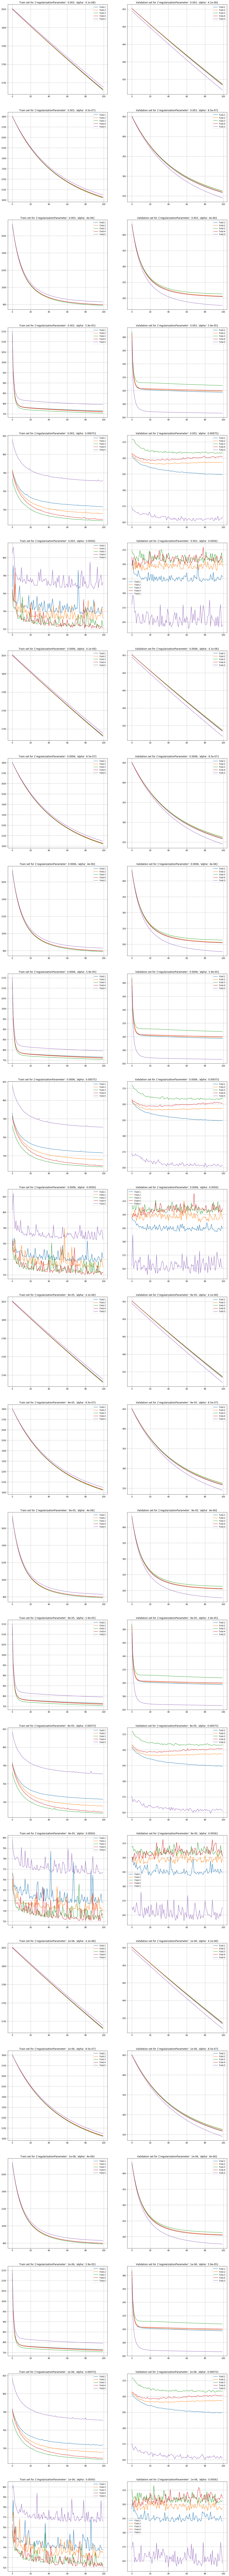

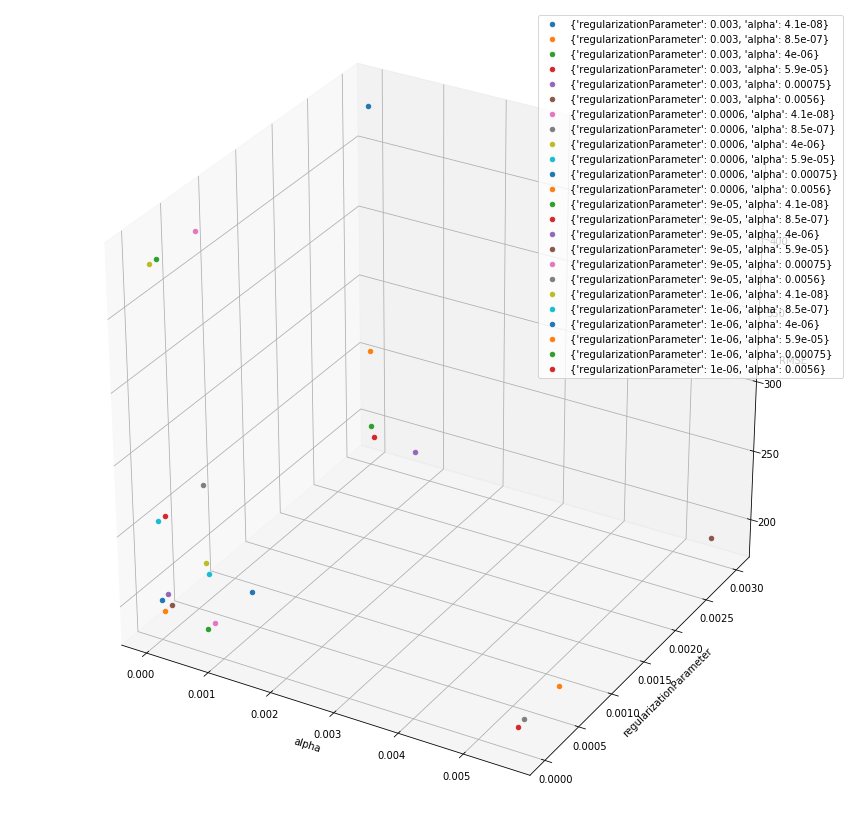

Trainloss :957.5902523467445
Testloss :921.6900346332518


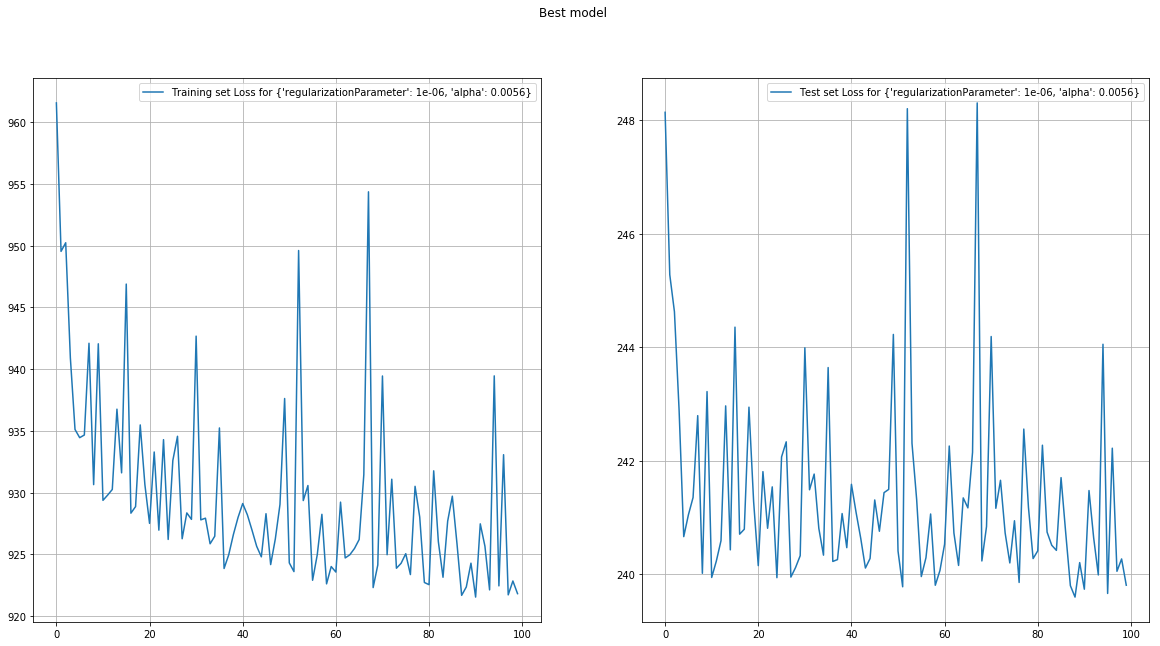

In [124]:
#Mini Batch Gradient Decent with K(5)-fold cross validation for Bank Dataset with regularisation
gridParameters = {
    "alpha":[4.1e-8, 8.5e-7, 4.0e-6, 5.9e-5, 7.5e-4, 5.6e-3],
    "regularizationParameter":[3e-3, 6e-4, 9e-5, 1e-6]
}
modelParameters = {
    "beta":np.zeros(x_Train.shape[1] + 1), 
    "epochs":100, 
    "batchSize":50, 
    "regularization" : l2Loss
}
model, hyperParams = gridSearch(x_Train, y_Train, x_Test, y_Test, 
           logisticregminibatch, modelParameters, gridParameters, nFolds = 5)

In [46]:
#Winedata preprocessing
winewhite_data = pd.read_csv('winequality-white.csv', delimiter = ';')

In [47]:
#Normalise wine dataset
for feature in winewhite_data.columns:
    if feature != "quality":
        winewhite_data[feature] = normalize(winewhite_data[feature])
winewhite_data.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.307692          0.186275     0.216867        0.308282   0.106825   
1       0.240385          0.215686     0.204819        0.015337   0.118694   
2       0.413462          0.196078     0.240964        0.096626   0.121662   
3       0.326923          0.147059     0.192771        0.121166   0.145401   
4       0.326923          0.147059     0.192771        0.121166   0.145401   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.149826              0.373550  0.267785  0.254545   0.267442   
1             0.041812              0.285383  0.132832  0.527273   0.313953   
2             0.097561              0.204176  0.154039  0.490909   0.255814   
3             0.156794              0.410673  0.163678  0.427273   0.209302   
4             0.156794              0.410673  0.163678  0.427273   0.209302   

    alcohol  quality  
0  0.129032        6  
1  0.241935        6  
2  0.338710        6  
3  0.306452        6  
4  0.306452        6

In [48]:
#Split wine dataset
trainSet1, testSet1 = split_DataSet(winewhite_data, 0.8)
x_Train1 = trainSet1.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
x_Test1 = testSet1.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
y_Train1 = trainSet1['quality']
y_Test1 = testSet1['quality']

C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Iteration = 1 Alpha = 0.004 lambda = 9.9e-09
Non Regularized Trainloss :0.7637140113602432
Regularised Trainloss :0.7650750157848853
Iteration = 2 Alpha = 0.00059 lambda = 1.9e-07
Non Regularized Trainloss :0.7640419393860687
Regularised Trainloss :0.7641348341128104
Iteration = 3 Alpha = 9.1e-05 lambda = 0.0059
Non Regularized Trainloss :0.7683246581172916
Regularised Trainloss :0.7683881889203722


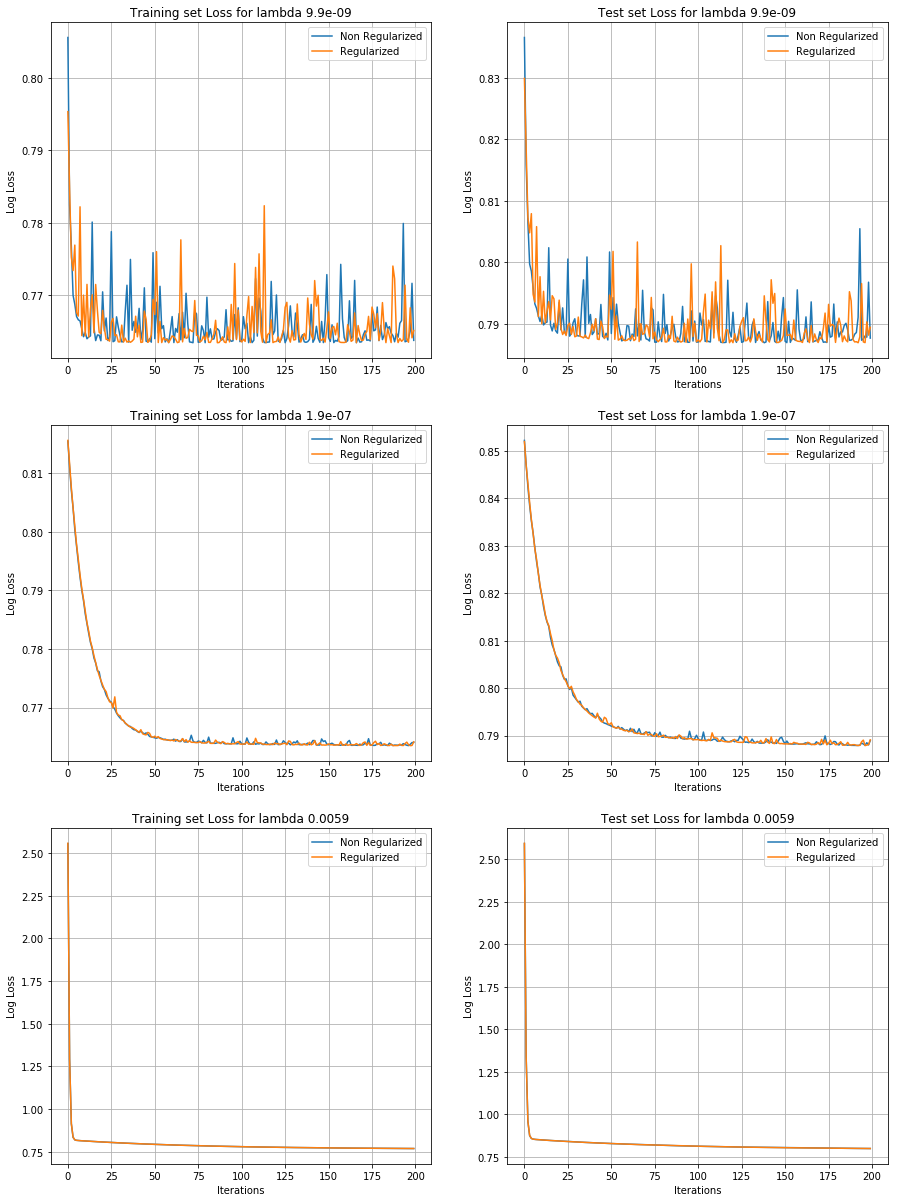

In [53]:
#Mini Batch Gradient Decent for wine Dataset with regularisation
plt.close()
modelParameters = {"beta":np.zeros(x_Train1.shape[1] + 1), "epochs":200, 
                   "batchSize":50}
alphaList = [4.0e-3, 5.9e-4, 9.1e-5]
regularizationParameterList = [9.9e-9, 1.9e-7, 5.9e-3]
index = 0
fig, axs = plt.subplots(len(alphaList), 2, figsize=(15, 7 * len(alphaList)))
#print("axs :"+str(axs))
for alpha, regularizationParameter in zip(alphaList, regularizationParameterList):
    betaNonReg, trainLossNonReg, testLossNonReg = logisticregminibatch(x_Train1, y_Train1, x_Test1
                                                                       , y_Test1,alpha = alpha, **modelParameters)
    
    
    betaReg, trainLossReg, testLossReg = logisticregminibatch(x_Train1, y_Train1, x_Test1,
                                                                           y_Test1,alpha = alpha, regularization = l2Loss,
                                                                      regularizationParameter = regularizationParameter,
                                                                      **modelParameters)
    print("Iteration =" ,str(index+1) , "Alpha =",str(alpha), "lambda =",str(regularizationParameter))
    print("Non Regularized Trainloss :"+str(trainLossNonReg[-1]))
    print("Regularised Trainloss :"+str(trainLossReg[-1]))
    axs[index][0].set_xlabel("Iterations")
    axs[index][1].set_xlabel("Iterations")
    axs[index][0].set_ylabel("Log Loss")
    axs[index][1].set_ylabel("Log Loss")    
    axs[index][0].plot(trainLossNonReg, label = "Non Regularized")
    axs[index][0].plot(trainLossReg, label = "Regularized")
    axs[index][0].title.set_text("Training set Loss for lambda " +str(regularizationParameter))
    axs[index][0].grid()
    axs[index][0].legend()    
    axs[index][1].plot(testLossNonReg, label = "Non Regularized")
    axs[index][1].plot(testLossReg, label = "Regularized")
    axs[index][1].title.set_text("Test set Loss for lambda " + str(regularizationParameter))
    axs[index][1].grid()
    axs[index][1].legend()
    index = index + 1
plt.show()

mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 5.9e-07}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 5e-06}
mesh {'regularizationParameter': 0.003}
mesh {'regularizationParameter': 0.003, 'alpha': 4e-05}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 5.9e-07}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 5e-06}
mesh {'regularizationParameter': 0.0006}
mesh {'regularizationParameter': 0.0006, 'alpha': 4e-05}
mesh {'regularizationParameter': 9e-05}
mesh {'regularizationParameter': 9e-05, 'alpha': 5.9e-07}
mesh {'regularizationParameter': 9e-05}
mesh {'regularizationParameter': 9e-05, 'alpha': 5e-06}
mesh {'regularizationParameter': 9e-05}
mesh {'regularizationParameter': 9e-05, 'alpha': 4e-05}


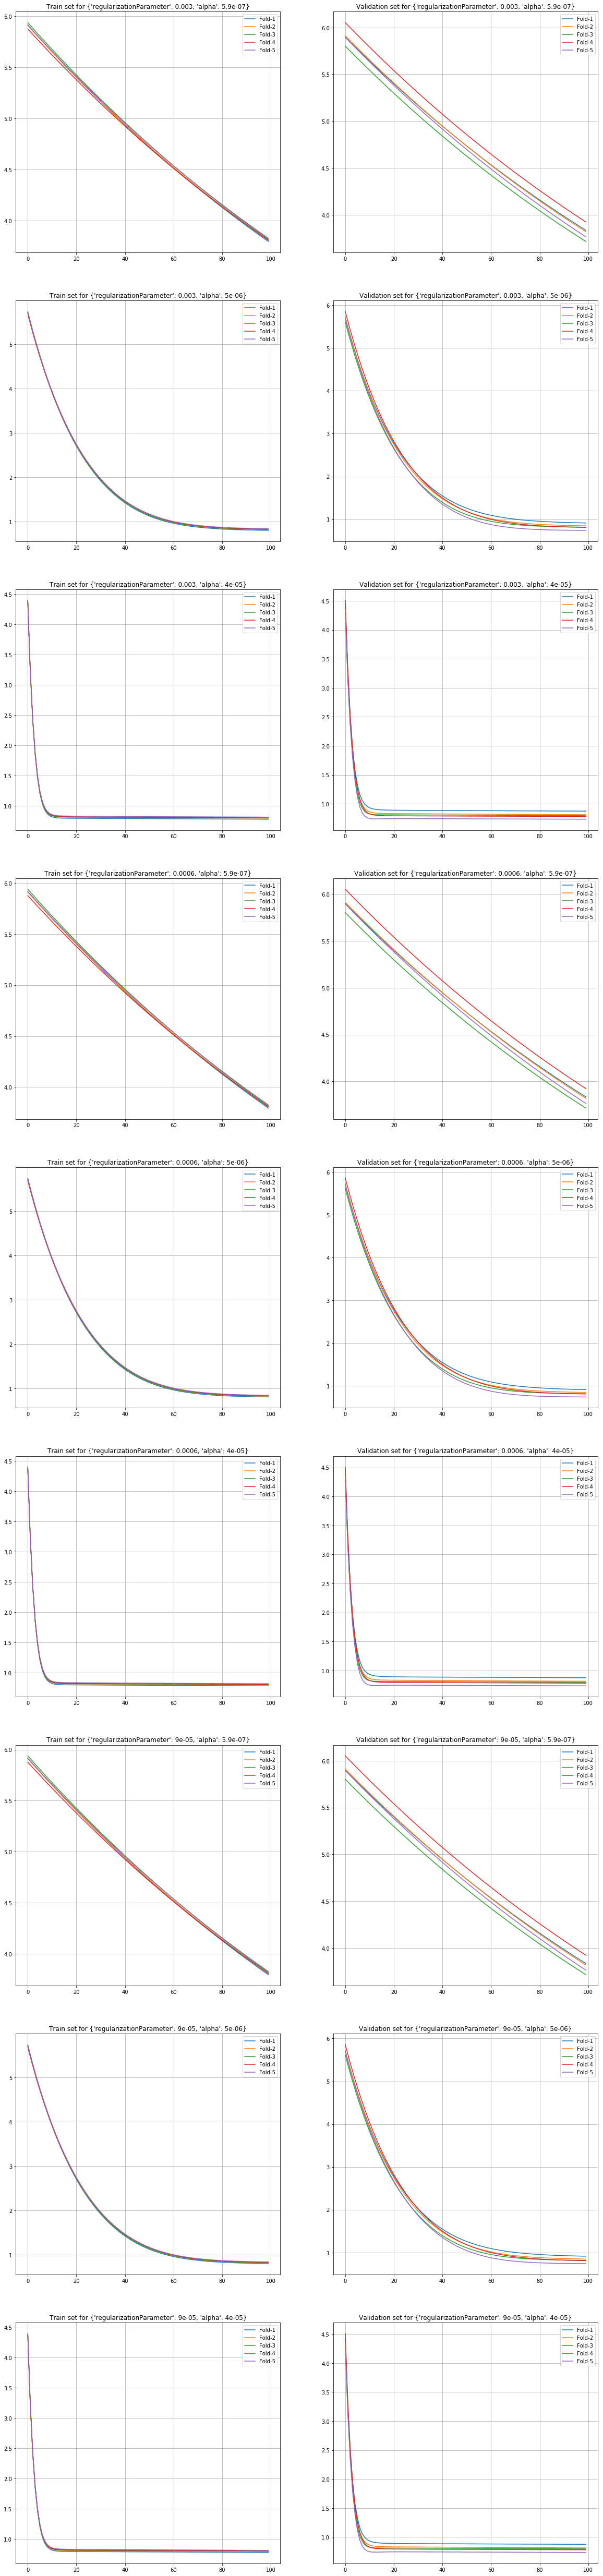

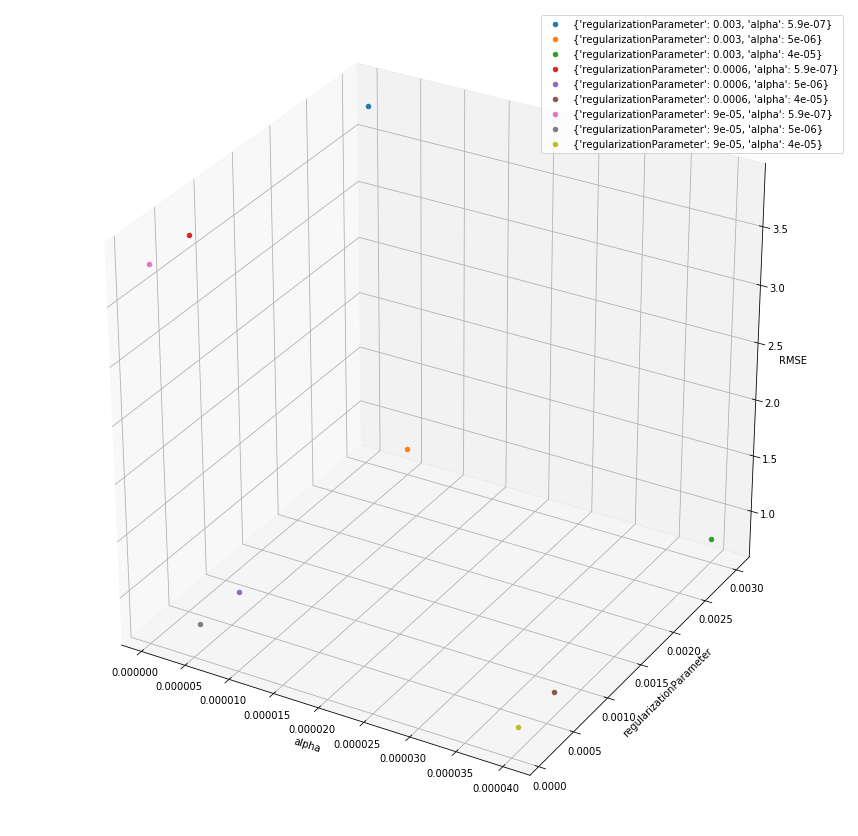

Trainloss :0.7683246581172916
Testloss :0.7683881889203722


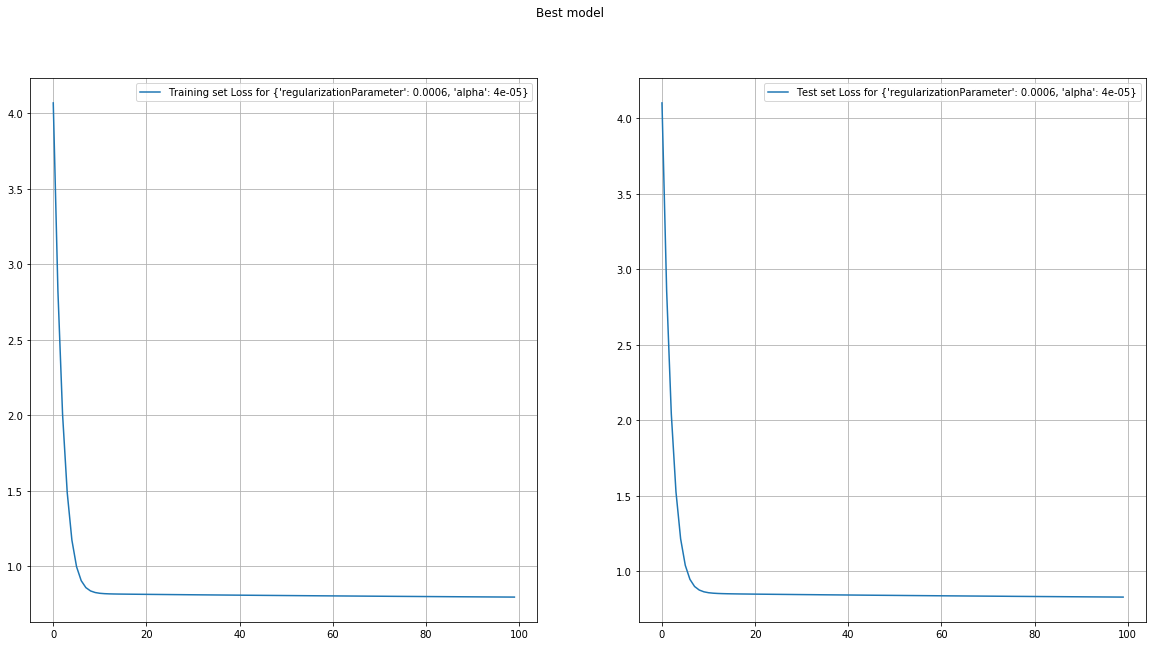

In [57]:
#Mini Batch Gradient Decent with K(5)-fold cross validation for wine Dataset with regularisation
gridParameters = {
    "alpha":[5.9e-7, 5.0e-6, 4.0e-5],
    "regularizationParameter":[3e-3, 6e-4, 9e-5]
}
modelParameters = {
    "beta":np.zeros(x_Train1.shape[1] + 1), 
    "epochs":100, 
    "batchSize":50, 
    "regularization" : l2Loss
}
model, hyperParams = gridSearch(x_Train1, y_Train1, x_Test1, y_Test1, 
           logisticregminibatch, modelParameters, gridParameters, nFolds = 5)